<a href="https://colab.research.google.com/github/ivan-mihailov/LS-Unit-2-Sprint-2-Assignments/blob/main/DS_Sprint_Challenge_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [25]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)
# YOUR CODE HERE
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format = True) # Transform 'game_date' into DateTime format
df = df.set_index('game_date') # Set 'game_date' as the index for the dataframe
df = df.drop('player_name', axis = 1) # Drop 'player_name' because the dataframe contains only shots taken by Steph Curry
df.head()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [26]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Task 1 Testing**

In [27]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [28]:
"""T2. Create new feature"""

# YOUR CODE HERE

# Create new feature for home court advantage with values of 1 for a home game and 0 for away game
df.loc[df['htm'] == 'GSW', 'home_adv'] = 1
df.loc[df['htm'] != 'GSW', 'home_adv'] = 0

# Create new feature long 3pt shot (value of 1 if shot_distance is more than 24 ft.; otherwise value of 0)
df.loc[df['shot_distance'] > 24, 'long_3pt'] = 1
df.loc[df['shot_distance'] <= 24, 'long_3pt'] = 0

# Create new feature for clutch shot (value of 1 if less than 1 min remains in Quarter 4, 5, or 6; otherwise value of 0)
df.loc[((df['period'] == 1) | (df['period'] == 2) | (df['period'] == 3)), 'clutch_shot'] = 0
df.loc[(((df['period'] == 4) | (df['period'] == 5) | (df['period'] == 6)) & (df['minutes_remaining'] >= 1)), 'clutch_shot'] = 0
df.loc[(((df['period'] == 4) | (df['period'] == 5) | (df['period'] == 6)) & (df['minutes_remaining'] < 1)), 'clutch_shot'] = 1

In [29]:
# Transform new features from float to integer values
df['home_adv'] = df['home_adv'].astype(int)
df['long_3pt'] = df['long_3pt'].astype(int)
df['clutch_shot'] = df['clutch_shot'].astype(int)

In [30]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [31]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
target = 'shot_made_flag' # Set the target to equal the 'shot_made_flag' column
X = df.drop(target, axis=1) # Use .drop function to remove the target vector from the feature matrix
y=df[target] # Set the target vector

**Task 3 Test**

In [32]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [33]:
'''T4. Create training and val'''
# YOUR CODE HERE
train_cutoff = '2017-07-01' # Set the cutoff for the training set as the end of the 2017 season (earlier than July 1, 2017)
val_cutoff = '2018-07-01' # Set the cutoff for the validation set as the end of the 2018 season (earlier than July 1, 2018)
X_train = X[X.index < train_cutoff] # Create X_train and y_train based on index values earlier than the train_cutoff date
y_train = y[y.index < train_cutoff]
X_val = X[(X.index >= train_cutoff) & (X.index < val_cutoff)] # Create X_val and y_val based on index values later than the train_cutoff date and earlier than the val_cutoff date
y_val = y[(y.index >= train_cutoff) & (y.index < val_cutoff)]
X_test = X[X.index >= val_cutoff] # Create X_test and y_test based on index values later than the val_cutoff date
y_test = y[y.index >= val_cutoff]

**Test 4**

In [34]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [35]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
from sklearn.metrics import accuracy_score

majority_class = y_train.mode() # Determine the majority class for y_train using mode

y_pred = [majority_class] * len(y_train) # Assign the majority class to y_pred as as list of the same length as y_train

baseline_acc = accuracy_score(y_train, y_pred) # Calculate the accuracy score

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [36]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [49]:
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [58]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE

# Set-up the one-hot encoder method for low cardinality features
low_cat_features = ['shot_type',	'shot_zone_basic',	'shot_zone_area', 'shot_zone_range',	'season_type']
low_cat_transformer = make_pipeline(
    ce.OneHotEncoder(use_cat_names = True)
)

# Set-up the ordinal encoder method for high cardinality features
high_cat_features = ['action_type',	'htm',	'vtm']
high_cat_transformer = make_pipeline(
    ce.OrdinalEncoder()
)

# Set up the preprocessor/column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('low_cat', low_cat_transformer, low_cat_features),
        ('high_cat', high_cat_transformer, high_cat_features)])

# Set up pipeline with 2 transformers (within a preprocessor) and a RandomForestClassifier as estimator
model = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators = 300, random_state =  42, n_jobs = -1)
)

# Fit the pipeline with RandomForestClassifier estimator on the training set
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('low_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('onehotencoder',
                                                                   OneHotEncoder(cols=None,
                                                                                 drop_invariant=False,
                                                                                 handle_missing='value',
                                                                                 handle_unknown='value',
                                                                                 return_df=True,
                                     

**Task 6 Testing**

In [96]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [59]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train) # Calculate the accuracy score for the training set
val_acc = model.score(X_val, y_val) # Calculate the accuracy score for the validation set

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.774930060463857
Validation Accuracy Score: 0.5821917808219178


In [61]:
model.score(X_test, y_test) # Calculate the accuracy score for the test set using initial hyperparameters

0.6003510825043885

**Task 7 Test**

In [48]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [65]:
'''T8. Tune model.'''

# YOUR CODE HERE
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# Set up Random Forest Classifier parameters for Randomized Search to  to evaluate:
# n_estimators, criterion used, maximum tree depth, number of features and the max_samples

param_dist = {
    'randomforestclassifier__n_estimators' : randint(75, 300),
    'randomforestclassifier__criterion' : ['gini', 'entropy'],
    'randomforestclassifier__max_depth' : [10, 20, 25, None],
    'randomforestclassifier__max_features' : np.arange(1, len(X_train.columns)+1),
    'randomforestclassifier__max_samples' : uniform(0, 1)
}

# Set up a Randomized Search to optimize hyperparameters
search = RandomizedSearchCV(
    model,
    param_distributions = param_dist,
    n_iter = 3,
    scoring = 'accuracy',
    verbose = 10,
    cv = 2,
    n_jobs = -1,
    refit = True,
    return_train_score = True
)

search.fit(X_train, y_train) 

test_pipeline = search.best_estimator_ # Set up pipeline for test set using the Randomized Search optimized hyperparameters
y_pred_test = test_pipeline.predict(X_test) # Predict target vector for the test set using the Randomized Search optimized hyperparameters
test_acc = accuracy_score(y_test, y_pred_test) # Calculate the accuracy score for the test set using the Randomized Search optimized hyperparameters

print('Testing Accuracy Score:', test_acc)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    5.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    8.3s finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Testing Accuracy Score: 0.6143943826799297


**Task 8 Testing**

In [66]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

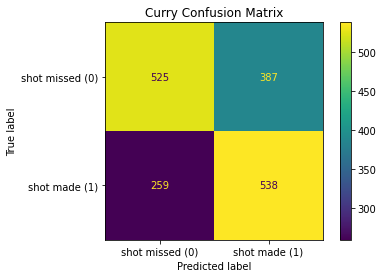

In [97]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
instructor_precision = 538/(538 + 387) # Precision for shot_made
instructor_recall = 538/(538 + 259) # Recall for shot_made
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


In [83]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

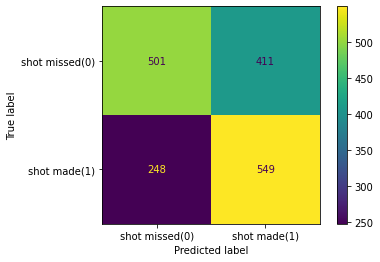

In [88]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_auc_score

plot_confusion_matrix(test_pipeline, X_test, y_test, values_format='.0f', display_labels=['shot missed(0)', 'shot made(1)'])


In [76]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60       912
           1       0.57      0.69      0.62       797

    accuracy                           0.61      1709
   macro avg       0.62      0.62      0.61      1709
weighted avg       0.62      0.61      0.61      1709



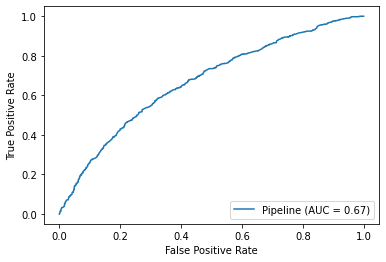

In [89]:
plot_roc_curve(test_pipeline, X_test, y_test)

In [95]:
y_score = test_pipeline.predict_proba(X_test)[:, 1]
print('The ROC_AUC score is:', roc_auc_score(y_test, y_score))

The ROC_AUC score is: 0.6693274120055472
